<a href="https://colab.research.google.com/github/Buse-cetin/Machine-Learning/blob/main/Whisper_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pydub

In [ ]:
!unzip "/content/drive/MyDrive/MachineLearning/whisper/data_whspr.zip"

Archive:  /content/drive/MyDrive/MachineLearning/whisper/data_whspr.zip
   creating: data_whspr/Background Noise/
  inflating: data_whspr/Background Noise/Noise_12 Track 061.mp3  
  inflating: data_whspr/Background Noise/Noise_12 Track 062.mp3  
  inflating: data_whspr/Background Noise/Noise_12 Track 063.mp3  
  inflating: data_whspr/Background Noise/Noise_12 Track 064.mp3  
  inflating: data_whspr/Background Noise/Noise_12 Track 065.mp3  
  inflating: data_whspr/Background Noise/Noise_12 Track 066.mp3  
  inflating: data_whspr/Background Noise/Noise_12 Track 067.mp3  
  inflating: data_whspr/Background Noise/Noise_12 Track 068.mp3  
  inflating: data_whspr/Background Noise/Noise_12 Track 069.mp3  
  inflating: data_whspr/Background Noise/Noise_12 Track 070.mp3  
  inflating: data_whspr/Background Noise/Noise_12 Track 071.mp3  
  inflating: data_whspr/Background Noise/Noise_12 Track 072.mp3  
  inflating: data_whspr/Background Noise/Noise_12 Track 073.mp3  
  inflating: data_whspr/Back

In [ ]:
import os
from pydub import AudioSegment
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Verilerin ve sınıfların yolları
data_dir = '/content/data_whspr'
output_dir = '/content/data'
classes = ['Background Noise','Choppy Speech','Competing Speaker','Echo Effects']


# Çıktı dizinini oluşturma
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Her bir sınıf için ses dosyalarını işleme
for label, class_name in enumerate(classes):
    class_dir = os.path.join(data_dir, class_name)
    class_output_dir = os.path.join(output_dir, class_name)
    os.makedirs(class_output_dir, exist_ok=True)

    for filename in os.listdir(class_dir):
        if filename.endswith('.mp3 adlı dosyanın kopyası'):
            file_path = os.path.join(class_dir, filename)
            audio = AudioSegment.from_file(file_path, format='mp3')

            # 10 saniyelik segmentlere ayırma
            duration = 5 * 1000  # 10 saniye milisaniye cinsinden
            for i in range(0, len(audio), duration):
                segment = audio[i:i + duration]
                if len(segment) < duration:
                    segment = segment + AudioSegment.silent(duration - len(segment))  # 10 saniyeye tamamla
                segment_filename = f'{os.path.splitext(filename)[0]}_{i // duration}.mp3'
                segment_path = os.path.join(class_output_dir, segment_filename)
                segment.export(segment_path, format='mp3')

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from pydub import AudioSegment
import io
import librosa

In [ ]:
# Segmentleri ve etiketleri yüklemek için listeler
segments = []
labels = []

# Segmentleri yükleme
for label, class_name in enumerate(classes):
    class_output_dir = os.path.join(output_dir, class_name)

    for filename in os.listdir(class_output_dir):
        if filename.endswith('.mp3'):
            file_path = os.path.join(class_output_dir, filename)
            audio = AudioSegment.from_file(file_path, format='mp3')
            segment_array = np.array(audio.get_array_of_samples())

            # Check if the segment array has the same shape as the others
            if segments and segment_array.shape != segments[0].shape:
                # Resize the segment array to match the other elements
                segment_array = librosa.util.normalize(segment_array)
                segment_array = librosa.util.fix_length(segment_array, size=segments[0].shape[0])

            segments.append(segment_array)
            labels.append(label)

In [ ]:
# Segmentleri ve etiketleri numpy dizilerine dönüştürme
segments_np = np.array(segments)
labels_np = np.array(labels)

In [ ]:
# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(segments_np, labels_np, test_size=0.2, random_state=42)

In [ ]:
print(f'Toplam segment sayısı: {len(segments_np)}')
print(f'Eğitim seti segment sayısı: {len(X_train)}')
print(f'Test seti segment sayısı: {len(X_test)}')

Toplam segment sayısı: 800
Eğitim seti segment sayısı: 640
Test seti segment sayısı: 160


In [ ]:
from transformers import AutoFeatureExtractor, WhisperForAudioClassification
import torch
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# AutoFeatureExtractor'ı başlatma
feature_extractor = AutoFeatureExtractor.from_pretrained("sanchit-gandhi/whisper-medium-fleurs-lang-id")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/339 [00:00<?, ?B/s]

In [ ]:
# Ses verilerini özelliklere dönüştürme
X_train_features = feature_extractor(X_train, sampling_rate=16000, return_tensors="pt")
X_test_features = feature_extractor(X_test, sampling_rate=16000, return_tensors="pt")

In [ ]:
print(X_train_features.keys())
print(X_test_features.keys())

dict_keys(['input_features'])
dict_keys(['input_features'])


In [ ]:
# Numpy verilerini PyTorch tensörlerine dönüştürme ve DataLoader oluşturma
train_dataset = TensorDataset(X_train_features['input_features'], torch.tensor(y_train))
test_dataset = TensorDataset(X_test_features['input_features'], torch.tensor(y_test))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4)

In [ ]:
# WhisperForAudioClassification modelini başlatma
model = WhisperForAudioClassification.from_pretrained("sanchit-gandhi/whisper-medium-fleurs-lang-id", num_labels=len(classes), ignore_mismatched_sizes=True)

config.json:   0%|          | 0.00/6.64k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/615M [00:00<?, ?B/s]

Some weights of WhisperForAudioClassification were not initialized from the model checkpoint at sanchit-gandhi/whisper-medium-fleurs-lang-id and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([102]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([102, 256]) in the checkpoint and torch.Size([4, 256]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Optimizasyon fonksiyonunu tanımlama
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

# Kayıp fonksiyonu tanımlama
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

WhisperForAudioClassification(
  (encoder): WhisperEncoder(
    (conv1): Conv1d(80, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(1024, 1024, kernel_size=(3,), stride=(2,), padding=(1,))
    (embed_positions): Embedding(1500, 1024)
    (layers): ModuleList(
      (0-23): 24 x WhisperEncoderLayer(
        (self_attn): WhisperSdpaAttention(
          (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (final_layer_norm): LayerNorm((1024,), eps=1

In [ ]:
def train_epoch(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    correct_predictions = 0

    for batch in train_loader:
        input_values, labels = batch
        input_values = input_values.to(device)
        labels = labels.to(device)

        outputs = model(input_values.to(device))
        logits = outputs.logits.to(device)
        loss = loss_fn(logits, labels)

        total_loss += loss.item()
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return total_loss / len(train_loader), correct_predictions.double() / len(train_loader.dataset)

In [ ]:
all_preds = []
all_labels = []

def eval_model(model, test_loader, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in test_loader:
            input_values, labels = batch
            input_values = input_values.to(device)
            labels = labels.to(device)

            outputs = model(input_values.to(device))
            logits = outputs.logits.to(device)
            loss = loss_fn(logits, labels)

            total_loss += loss.item()
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(test_loader), correct_predictions.double() / len(test_loader.dataset), all_preds, all_labels

In [ ]:
num_epochs = 5
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [ ]:
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')

    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    test_loss, test_acc, test_preds, test_labels = eval_model(model, test_loader, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f'Train Loss: {train_loss}, Train Accuracy: {train_acc}')
    print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

Epoch 1/5
Train Loss: 1.4336611058562994, Train Accuracy: 0.2671875
Test Loss: 1.3950797349214554, Test Accuracy: 0.23750000000000002
Epoch 2/5
Train Loss: 1.364730852097273, Train Accuracy: 0.3140625
Test Loss: 1.3410565584897995, Test Accuracy: 0.3875
Epoch 3/5
Train Loss: 1.2952413570135832, Train Accuracy: 0.4109375
Test Loss: 1.2584494560956956, Test Accuracy: 0.39375000000000004
Epoch 4/5
Train Loss: 1.2233880557119847, Train Accuracy: 0.40625
Test Loss: 1.2506951242685318, Test Accuracy: 0.35625
Epoch 5/5
Train Loss: 1.1801830902695656, Train Accuracy: 0.42500000000000004
Test Loss: 1.2062621489167213, Test Accuracy: 0.4


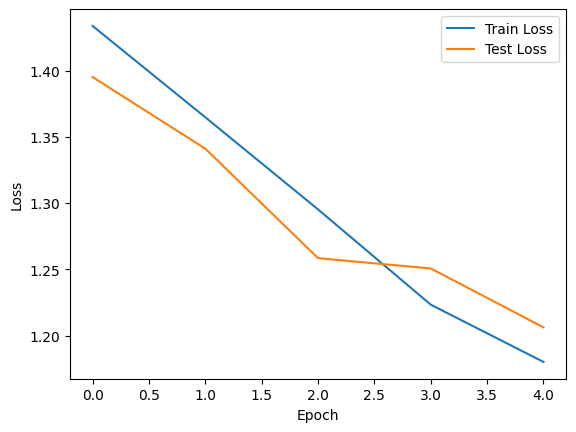

In [ ]:
# Accuracy ve loss grafikleri
plt.figure()
plt.subplot(1, 1, 1)
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

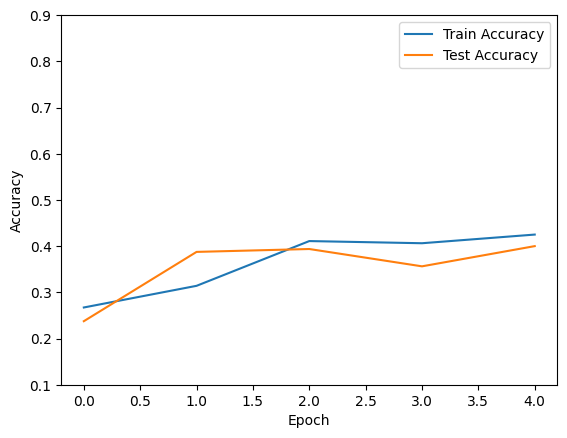

In [ ]:
# plt.subplot(1, 2, 2)
# plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy')
# plt.plot(range(num_epochs), test_accuracies, label='Test Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# Train accuracy verilerini CPU belleğine kopyala
train_accuracies_cpu = [acc.cpu().numpy() for acc in train_accuracies]
test_accuracies_cpu = [acc.cpu().numpy() for acc in test_accuracies]

# Grafik çizdirme işlemi
plt.figure()
plt.subplot(1, 1, 1)
plt.plot(range(num_epochs), train_accuracies_cpu, label='Train Accuracy')
plt.plot(range(num_epochs), test_accuracies_cpu, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.yticks([i/10 for i in range(1, 10)])
plt.legend()

In [ ]:
plt.show()

In [ ]:
# Precision, Recall, F1-Score hesaplama
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='macro')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

Precision: 0.3570646087858348
Recall: 0.3673981622818832
F1-Score: 0.3532333818789081


In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np

def plot_roc_curve(fold_results):
    all_true_labels = all_labels
    all_predicted_probs = []

    for fold_result in fold_results:
        test_preds, test_labels = fold_result['test_preds'], fold_result['test_labels']
        all_true_labels.extend(test_labels)
        all_predicted_probs.extend(test_preds)

    fpr, tpr, thresholds = roc_curve(all_true_labels, all_predicted_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Roc eğrisini çizme
plot_roc_curve(fold_results)


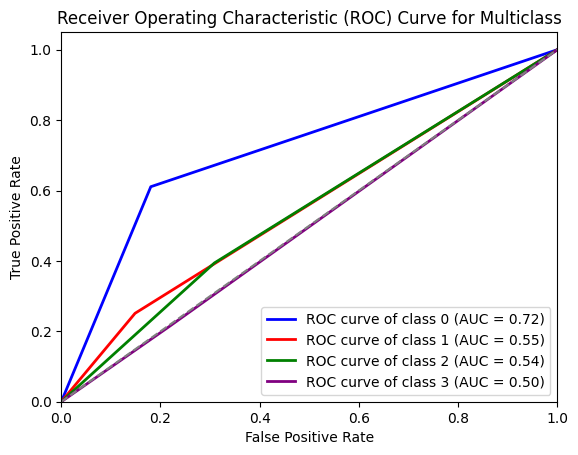

In [ ]:
from sklearn.metrics import auc, roc_curve, roc_auc_score, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import label_binarize

labels = np.array(all_labels)
preds = np.array(all_preds)

# Sınıfları ikili hale getirin
n_classes = len(np.unique(labels))
labels = label_binarize(labels, classes=[0, 1, 2, 3])
preds = label_binarize(preds, classes=[0, 1, 2, 3,])

# Her sınıf için ROC ve AUC hesapla
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC eğrisini çizdir
plt.figure()
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass')
plt.legend(loc="lower right")
plt.show()

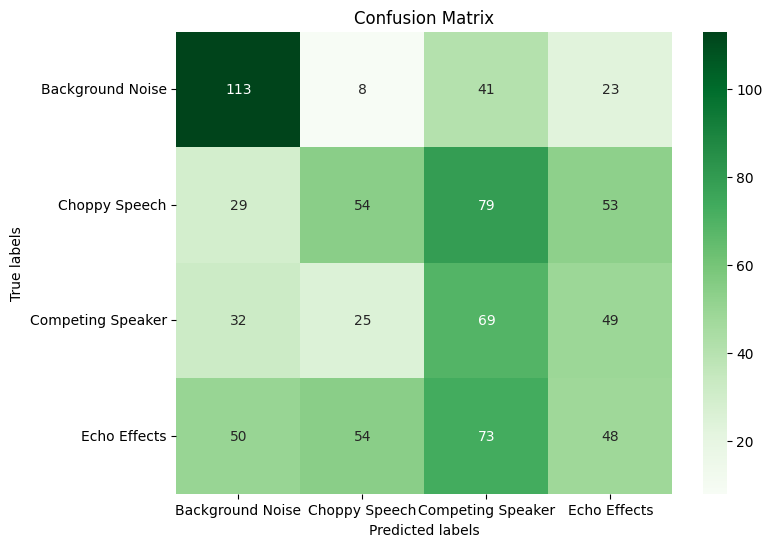

In [ ]:
# Confusion matrix oluştur
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

# Sınıfları ikili hale getirin
class_names = ['Background Noise','Choppy Speech','Competing Speaker','Echo Effects']

# Classification report oluştur
report = classification_report(labels, preds, target_names=class_names, output_dict=True)

# DataFrame'e dönüştür ve precision ve recall sütunlarını seç
df_report = pd.DataFrame(report).transpose()
df_precision_recall = df_report[['precision', 'recall']]

# Precision ve recall değerlerini tablo olarak yazdır
print(df_precision_recall)

# Eğer tabloları güzel bir şekilde yazdırmak isterseniz, tabulate kütüphanesini kullanabilirsiniz
try:
    from tabulate import tabulate
    print(tabulate(df_precision_recall, headers='keys', tablefmt='psql'))
except ImportError:
    print("Tabulate kütüphanesi yüklü değil. Tablolar düz metin olarak yazdırılıyor.")
    print(df_precision_recall)


                   precision    recall
Background Noise    0.504464  0.610811
Choppy Speech       0.382979  0.251163
Competing Speaker   0.263359  0.394286
Echo Effects        0.277457  0.213333
micro avg           0.355000  0.355000
macro avg           0.357065  0.367398
weighted avg        0.355227  0.355000
samples avg         0.355000  0.355000
+-------------------+-------------+----------+
|                   |   precision |   recall |
|-------------------+-------------+----------|
| Background Noise  |    0.504464 | 0.610811 |
| Choppy Speech     |    0.382979 | 0.251163 |
| Competing Speaker |    0.263359 | 0.394286 |
| Echo Effects      |    0.277457 | 0.213333 |
| micro avg         |    0.355    | 0.355    |
| macro avg         |    0.357065 | 0.367398 |
| weighted avg      |    0.355227 | 0.355    |
| samples avg       |    0.355    | 0.355    |
+-------------------+-------------+----------+


cross validation

In [ ]:
from sklearn.model_selection import StratifiedKFold

def k_fold_cross_validation(model, optimizer, loss_fn, train_dataset, num_epochs, k=3):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(train_dataset.tensors[0], train_dataset.tensors[1])):
        print(f'Fold {fold + 1}/{k}')

        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)

        train_loader_fold = torch.utils.data.DataLoader(train_dataset, batch_size=train_loader.batch_size, sampler=train_subsampler)
        test_loader_fold = torch.utils.data.DataLoader(train_dataset, batch_size=train_loader.batch_size, sampler=test_subsampler)

        model.to(device)
        model.train()

        train_losses = []
        test_losses = []
        train_accuracies = []
        test_accuracies = []

        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}')

            train_loss, train_acc = train_epoch(model, train_loader_fold, optimizer, device)
            test_loss, test_acc, _, _ = eval_model(model, test_loader_fold, device)

            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)

            print(f'Train Loss: {train_loss}, Train Accuracy: {train_acc}')
            print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

        fold_results.append({
            'train_losses': train_losses,
            'test_losses': test_losses,
            'train_accuracies': train_accuracies,
            'test_accuracies': test_accuracies
        })

    return fold_results

# Kullanılacak parametreler
num_epochs = 4
learning_rate = 5e-5

# Model, optimizer ve loss fonksiyonları
model = WhisperForAudioClassification.from_pretrained("sanchit-gandhi/whisper-medium-fleurs-lang-id", num_labels=len(classes), ignore_mismatched_sizes=True)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

# Cross-validation yapma
train_dataset = TensorDataset(X_train_features['input_features'], torch.tensor(y_train))
fold_results = k_fold_cross_validation(model, optimizer, loss_fn, train_dataset, num_epochs)


Some weights of WhisperForAudioClassification were not initialized from the model checkpoint at sanchit-gandhi/whisper-medium-fleurs-lang-id and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([102]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([102, 256]) in the checkpoint and torch.Size([4, 256]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 1/3
Epoch 1/4
Train Loss: 1.4279617539076048, Train Accuracy: 0.17500000000000002
Test Loss: 1.3833490720501653, Test Accuracy: 0.08750000000000001
Epoch 2/4
Train Loss: 1.3860661092205582, Train Accuracy: 0.1625
Test Loss: 1.38633288498278, Test Accuracy: 0.0859375
Epoch 3/4
Train Loss: 1.3832069067197426, Train Accuracy: 0.1625
Test Loss: 1.3802920248773363, Test Accuracy: 0.08750000000000001
Epoch 4/4
Train Loss: 1.3941470774534708, Train Accuracy: 0.1703125
Test Loss: 1.390099008878072, Test Accuracy: 0.084375
Fold 2/3
Epoch 1/4
Train Loss: 1.3835286447935016, Train Accuracy: 0.15625
Test Loss: 1.3748976389567058, Test Accuracy: 0.0890625
Epoch 2/4
Train Loss: 1.3808639484031178, Train Accuracy: 0.15937500000000002
Test Loss: 1.3900429760968243, Test Accuracy: 0.0859375
Epoch 3/4
Train Loss: 1.3841471248698012, Train Accuracy: 0.1640625
Test Loss: 1.3861744050626401, Test Accuracy: 0.0859375
Epoch 4/4
Train Loss: 1.5206447772890608, Train Accuracy: 0.1484375
Test Loss: 1.43649

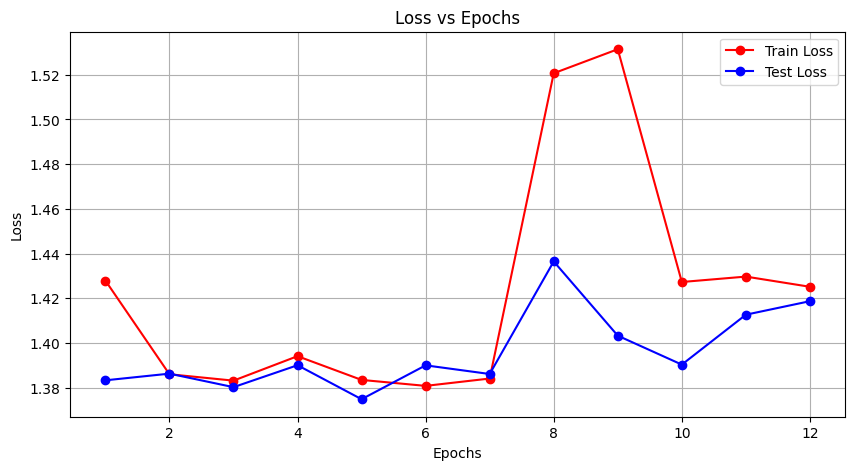

In [ ]:
import matplotlib.pyplot as plt

# Kayıp değerlerinin normal formata dönüştürülmesi
scaled_train_losses = [loss * 1e5 for loss in d_training_losses]
scaled_test_losses = [loss * 1e5 for loss in d_validation_losses]

# Epoch sayısını belirleme
num_epochs = len(d_training_losses)
epochs = range(1, num_epochs + 1)

# Grafik oluşturma
plt.figure(figsize=(10, 5))
plt.plot(epochs, scaled_train_losses, 'r-o', label='Train Loss')
plt.plot(epochs, scaled_test_losses, 'b-o', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')

# Y ekseni etiketlerinin düzenlenmesi
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.legend()
plt.grid(True)
plt.show()



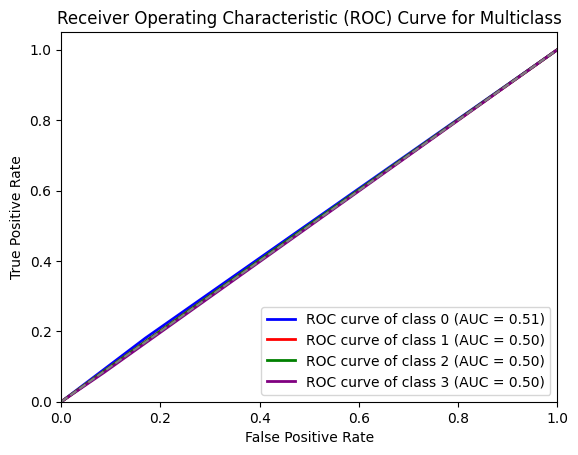

In [ ]:
from sklearn.metrics import auc, roc_curve, roc_auc_score, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import label_binarize

labels = np.array(all_labels)
preds = np.array(all_preds)

# Sınıfları ikili hale getirin
n_classes = len(np.unique(labels))
labels = label_binarize(labels, classes=[0, 1, 2, 3])
preds = label_binarize(preds, classes=[0, 1, 2, 3,])

# Her sınıf için ROC ve AUC hesapla
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC eğrisini çizdir
plt.figure()
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

# Sınıfları ikili hale getirin
class_names = ['Background Noise','Choppy Speech','Competing Speaker','Echo Effects']

# Classification report oluştur
report = classification_report(labels, preds, target_names=class_names, output_dict=True)

# DataFrame'e dönüştür ve precision ve recall sütunlarını seç
df_report = pd.DataFrame(report).transpose()
df_precision_recall = df_report[['precision', 'recall']]

# Precision ve recall değerlerini tablo olarak yazdır
print(df_precision_recall)

# Eğer tabloları güzel bir şekilde yazdırmak isterseniz, tabulate kütüphanesini kullanabilirsiniz
try:
    from tabulate import tabulate
    print(tabulate(df_precision_recall, headers='keys', tablefmt='psql'))
except ImportError:
    print("Tabulate kütüphanesi yüklü değil. Tablolar düz metin olarak yazdırılıyor.")
    print(df_precision_recall)


                   precision    recall
Background Noise    0.266968  0.180982
Choppy Speech       0.246445  0.248408
Competing Speaker   0.258703  0.495455
Echo Effects        0.235294  0.083871
micro avg           0.255078  0.255078
macro avg           0.251853  0.252179
weighted avg        0.252132  0.255078
samples avg         0.255078  0.255078
+-------------------+-------------+----------+
|                   |   precision |   recall |
|-------------------+-------------+----------|
| Background Noise  |    0.266968 | 0.180982 |
| Choppy Speech     |    0.246445 | 0.248408 |
| Competing Speaker |    0.258703 | 0.495455 |
| Echo Effects      |    0.235294 | 0.083871 |
| micro avg         |    0.255078 | 0.255078 |
| macro avg         |    0.251853 | 0.252179 |
| weighted avg      |    0.252132 | 0.255078 |
| samples avg       |    0.255078 | 0.255078 |
+-------------------+-------------+----------+
